# Projet n°5 : Segmentez des clients d'un site e-commerce - Phase Maintenance

Ce notebook a pour objectif d'estimer une périodicité dans la maintenance de la modélisation faite avec 8 clusters, où K = 8, que l'on peut retrouver dans le notebook n°2.
Nous allons reprendre ce modèle, puis calculer l'évolution de son ARI Score, et lire ces variations. Nous aurons ainsi une vision de la stabilité de nos clusters dans le temps de nos clients de 2017 avec l'arrivée de nouveaux clients sur l'année 2018, et nous déterminerons un seuil qui sera entre 80% et 85%.

Démarche employée pour répondre à cela :

1. Créer les variations dans le temps de la base de données clients, c'est à dire agrégée et composée des features utilisées dans le modèle grâce à une fonction pour automatiser le processus.
2. Générer les dataframes pour avoir une photographie dans le temps de l'évolution de la base de données clients grâce à la fonction créée
3. Avec joblib, le modèle utilisé dans le notebook n°2 sera instancié puis avec un .predict faire une prédiction sur les différentes périodes :
   - toute l'année 2017
   - puis faire un cumul mensuel itératif pour mettre en avant l'arrivée de nouveaux clients, tout en gardant les clients de 2017.
4. Mesurer la stabilité du clustering des clients de 2017, sur chaque mois de l'année 2018, pour voir l'impact de l'arrivée des nouveaux clients en 2018
5. Suite à la lecture déterminer notre ariscore est en dessous du seuil défini, pour définir une périodicité de maintenance du modèle présenté

# I. Importation des librairies & des données

## 1. Importer les librairies

In [14]:
# Librairies de base python 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import sqlite3
import missingno as msno

# librairies pour les algorithmes de machine learning
from sklearn.cluster import KMeans

# Métrique de performances
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score

# Importer les librairies de pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

## 2. Importer les données

Importer le dataframe df_commandes qui présente déjà une partie des données requises avec l'ensemble des commandes et des informations liée aux paiements, commentaires & aux produits. Ces données sont agrégées au niveau des commandes / order_id.
Nous allons devoir également importer notre base de données clients, pour avoir notre id unique par client.

In [2]:
# Importation du dataset commandes / orders
df_commande = pd.read_csv('df_commandes.csv')

In [3]:
# Chemin vers votre fichier de base de données
db_path = r'C:\Users\justi\OneDrive\Cours - Travail\DATA SCIENCE\Formation - DataScientist\Projet n°5\NOTEBOOK - DATA\olist.db'

# Connexion à la base de données
conn = sqlite3.connect(db_path)

# Utiliser pandas pour lire les données de la base de données dans un DataFrame
df_customers = pd.read_sql_query("SELECT * FROM customers", conn)

# Fermer la connexion à la base de données
conn.close()

In [4]:
# Afficher le dataset des commandes
df_commande.head(3)

,order_id,total_items,total_price,total_freight_value,avg_product_description_length,avg_product_weight_g,avg_product_volume_cm3,cat_Automotive,cat_Baby_Kids,cat_Electronics_Computers,...,paytype_voucher,payment_value,payment_type,payment_installments,2016,2017,2018,time_shipping,time_order,écart_Prév
0,00010242fe8c5a6d1ba2dd792cb16214,1,58.9,13.29,598.0,650.0,3528.0,0.0,0.0,0.0,...,0,72.19,credit_card,2,0,1,0,1.0,7.0,-9.0
1,00018f77f2f0320c557190d7a144bdd3,1,239.9,19.93,239.0,30000.0,60000.0,0.0,239.9,0.0,...,0,259.83,credit_card,3,0,1,0,8.0,16.0,-3.0
2,000229ec398224ef6ca0657da4fc703e,1,199.0,17.87,695.0,3050.0,14157.0,0.0,0.0,0.0,...,0,216.87,credit_card,5,0,0,1,6.0,7.0,-14.0


In [5]:
# Afficher le dataset des clients 
df_customers.head(3)

,index,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


# II. Stabilité des clusters avec l'ARI-Score

## 1. Création d'une fonction pour générer les features & les agrégations requises

In [6]:
# Enlevons les variables que nous n'avons pas utiliser dans le modèle intialement utilisé
colonne_to_dropped = [
                      'total_price',
                      'avg_product_description_length',
                      'cat_Automotive',
                      'cat_Baby_Kids',
                      'cat_Electronics_Computers',
                      'cat_Entertainment',
                      'cat_Fashion_Clothing',
                      'cat_Food_Drink',
                      'cat_Health_Beauty',
                      'cat_Home_Furniture',
                      'cat_Home_Garden',
                      'cat_Other',
                      'cat_Miscellaneous',
                      'cat_Tools_Construction',
                      'avg_délaiSatisfaction',
                      'payment_sequential',
                      'paytype_boleto',
                      'paytype_credit_card',
                      'paytype_debit_card',
                      'paytype_not_defined',
                      'paytype_voucher',
                      'payment_type',
                      'payment_installments',
                      'time_order'
                     ]

df_ari = df_commande.drop(colonne_to_dropped, axis = 1)

In [7]:
# Merge des DataFrames en utilisant la colonne 'customer_id' comme clé
df_ari = pd.merge(df_ari, df_customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')

# Supprimer la colonne customer_id car plus utile
df_ari = df_ari.drop(columns=['customer_id'])

In [8]:
# Plage temporelle du dataset
datemin = df_ari['order_purchase_timestamp'].min()
datemax = df_ari['order_purchase_timestamp'].max()
print('Date d\'achat la plus ancienne :', datemin)
print('Date d\'achat la plus récente  :' , datemax)

Date d'achat la plus ancienne : 2016-10-03 09:44:50
Date d'achat la plus récente  : 2018-08-29 15:00:37


La fonction suivante permet de générer les features et les agrégations nécessaires pour créer le dataset utiliser lors de la modélisation, en partant de la table df_commandes.
Nous pouvons donc générer les dataset sur des périodes précises et définies.
En l'occurence, ici nous allons créer un dataset pour l'année 2017, puis des datasets pour chaque mois de l'année 2018.
Cela nous sera utile pour calculer le ariscore et voir les variations de ce kpi sur les clients de 2017, avec l'ajout de nouveaux clients sur l'année 2018.

## 2. Générer des plusieurs dataframes agrégées sur des périodes de temps précises

In [9]:
def transformer_aggregations(df_ari, start_date=None, end_date=None):
    """
    Transform and aggregate features from a DataFrame containing order information.

    Parameters:
    df_ari (pd.DataFrame): DataFrame containing order data with columns including:
        - 'order_purchase_timestamp': Timestamp of the order purchase.
        - 'avg_review_score': Average review score for the order.
        - 'time_shipping': Shipping time for the order.
        - 'écart_Prév': Prediction error for the order.
        - 'order_id': Identifier of the order.
        - 'total_items': Total items in the order.
        - 'payment_value': Payment value of the order.
        - 'total_freight_value': Freight value of the order.
        - 'total_characters_review_comment_message': Total characters in the review comment message.
        - 'avg_product_weight_g': Average weight of the products in grams.
        - 'avg_product_volume_cm3': Average volume of the products in cubic centimeters.
        - '2016', '2017', '2018': Indicators of orders placed in the respective years.
    start_date (str or None): Start date to filter the data. Orders before this date will be excluded. Format: 'YYYY-MM-DD'.
    end_date (str or None): End date to filter the data. Orders after this date will be excluded. Format: 'YYYY-MM-DD'.

    Returns:
    pd.DataFrame: Aggregated DataFrame with the following columns:
        - 'customer_unique_id': Unique identifier for each customer.
        - 'total_orders': Total number of orders placed by the customer.
        - 'total_items': Total items ordered by the customer.
        - 'payment_value': Total payment value for the customer's orders.
        - 'total_characters_review_comment_message': Total characters in review comment messages.
        - 'avg_product_weight_g': Average weight of products in grams.
        - 'avg_product_volume_cm3': Average volume of products in cubic centimeters.
        - 'avg_review_score': Average review score.
        - 'time_shipping': Average shipping time.
        - 'ecart_Prev': Average prediction error.
        - 'oldest_order': Timestamp of the oldest order.
        - 'time_since_last_purch': Days since the last purchase.
        - 'tot_orders_2016': Total orders placed in 2016.
        - 'tot_orders_2017': Total orders placed in 2017.
        - 'tot_orders_2018': Total orders placed in 2018.
        - 'freight_payment_ratio': Ratio of total freight value to payment value.
        - 'single_mult_order': Indicator if the customer placed multiple orders (1) or a single order (0).

    Notes:
    - The DataFrame is first filtered by the specified date range, if provided.
    - Missing values in 'avg_review_score', 'time_shipping', and 'écart_Prév' are filled with their respective means.
    - The aggregation is performed by grouping the data by 'customer_unique_id' and calculating various statistics.
    - The 'time_since_last_purch' column is computed as the number of days since the last purchase up to the latest order date in the filtered data.
    - The 'single_mult_order' column indicates whether a customer placed more than one order.
    - The 'total_freight_value' column is dropped from the final aggregated DataFrame.
    """
# Conversion des dates en datetime
df_ari['order_purchase_timestamp'] = pd.to_datetime(df_ari['order_purchase_timestamp'])

# Fonction de création des features & d'agrégations
def transformer_aggregations(df_ari, start_date=None, end_date=None):
    df_ari['order_purchase_timestamp'] = pd.to_datetime(df_ari['order_purchase_timestamp'])
    
    if start_date:
        df_ari = df_ari[df_ari['order_purchase_timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        df_ari = df_ari[df_ari['order_purchase_timestamp'] <= pd.to_datetime(end_date)]
    
    df_ari['avg_review_score'] = df_ari['avg_review_score'].fillna(df_ari['avg_review_score'].mean())
    df_ari['time_shipping'] = df_ari['time_shipping'].fillna(df_ari['time_shipping'].mean())
    df_ari['écart_Prév'] = df_ari['écart_Prév'].fillna(df_ari['écart_Prév'].mean())
    
    aggregated_df = df_ari.groupby('customer_unique_id').agg(
        total_orders=('order_id', 'count'),
        total_items=('total_items', 'sum'),
        payment_value=('payment_value', 'sum'),
        total_freight_value=('total_freight_value', 'sum'),
        total_characters_review_comment_message=('total_characters_review_comment_message', 'sum'),
        avg_product_weight_g=('avg_product_weight_g', 'mean'),
        avg_product_volume_cm3=('avg_product_volume_cm3', 'mean'),
        avg_review_score=('avg_review_score', 'mean'),
        time_shipping=('time_shipping', 'mean'),
        ecart_Prev=('écart_Prév', 'mean'),
        oldest_order=('order_purchase_timestamp', 'min'),
        time_since_last_purch=('order_purchase_timestamp', 'max'),
        tot_orders_2016=('2016', 'sum'),
        tot_orders_2017=('2017', 'sum'),
        tot_orders_2018=('2018', 'sum')
    ).reset_index()
    
    aggregated_df['freight_payment_ratio'] = aggregated_df['total_freight_value'] / aggregated_df['payment_value']
    latest_order_date = df_ari['order_purchase_timestamp'].max()
    aggregated_df['time_since_last_purch'] = (latest_order_date - aggregated_df['time_since_last_purch']).dt.days
    aggregated_df['single_mult_order'] = aggregated_df['total_orders'].apply(lambda x: 1 if x > 1 else 0)
    aggregated_df = aggregated_df.drop(columns=['total_freight_value'])
    
    return aggregated_df

# Agrégation pour l'année 2017
df_2017 = transformer_aggregations(df_ari, start_date='2017-01-01', end_date='2017-12-31')

# Agrégations cumulatives pour chaque mois de 2018 jusqu'à septembre
results_2018 = {}

for month in range(1, 10):  # Arrêter à septembre (mois 9)
    start_date = '2017-01-01'
    end_date = f'2018-{month:02d}-28'  # Assurez-vous de gérer les mois avec différentes durées
    df_month = transformer_aggregations(df_ari, start_date=start_date, end_date=end_date)
    results_2018[f'2018-{month:02d}'] = df_month

# Affichage des résultats avec leurs shapes
print("Dataframe pour l'année 2017:")
print(f"2017: {df_2017.shape}")

print("\nDataframes cumulés pour chaque mois de 2018:")
for key, df in results_2018.items():
    print(f"{key}: {df.shape}")


Dataframe pour l'année 2017:
2017: (42066, 17)

Dataframes cumulés pour chaque mois de 2018:
2018-01: (48118, 17)
2018-02: (54972, 17)
2018-03: (61343, 17)
2018-04: (68075, 17)
2018-05: (74594, 17)
2018-06: (80497, 17)
2018-07: (86042, 17)
2018-08: (93057, 17)
2018-09: (93104, 17)


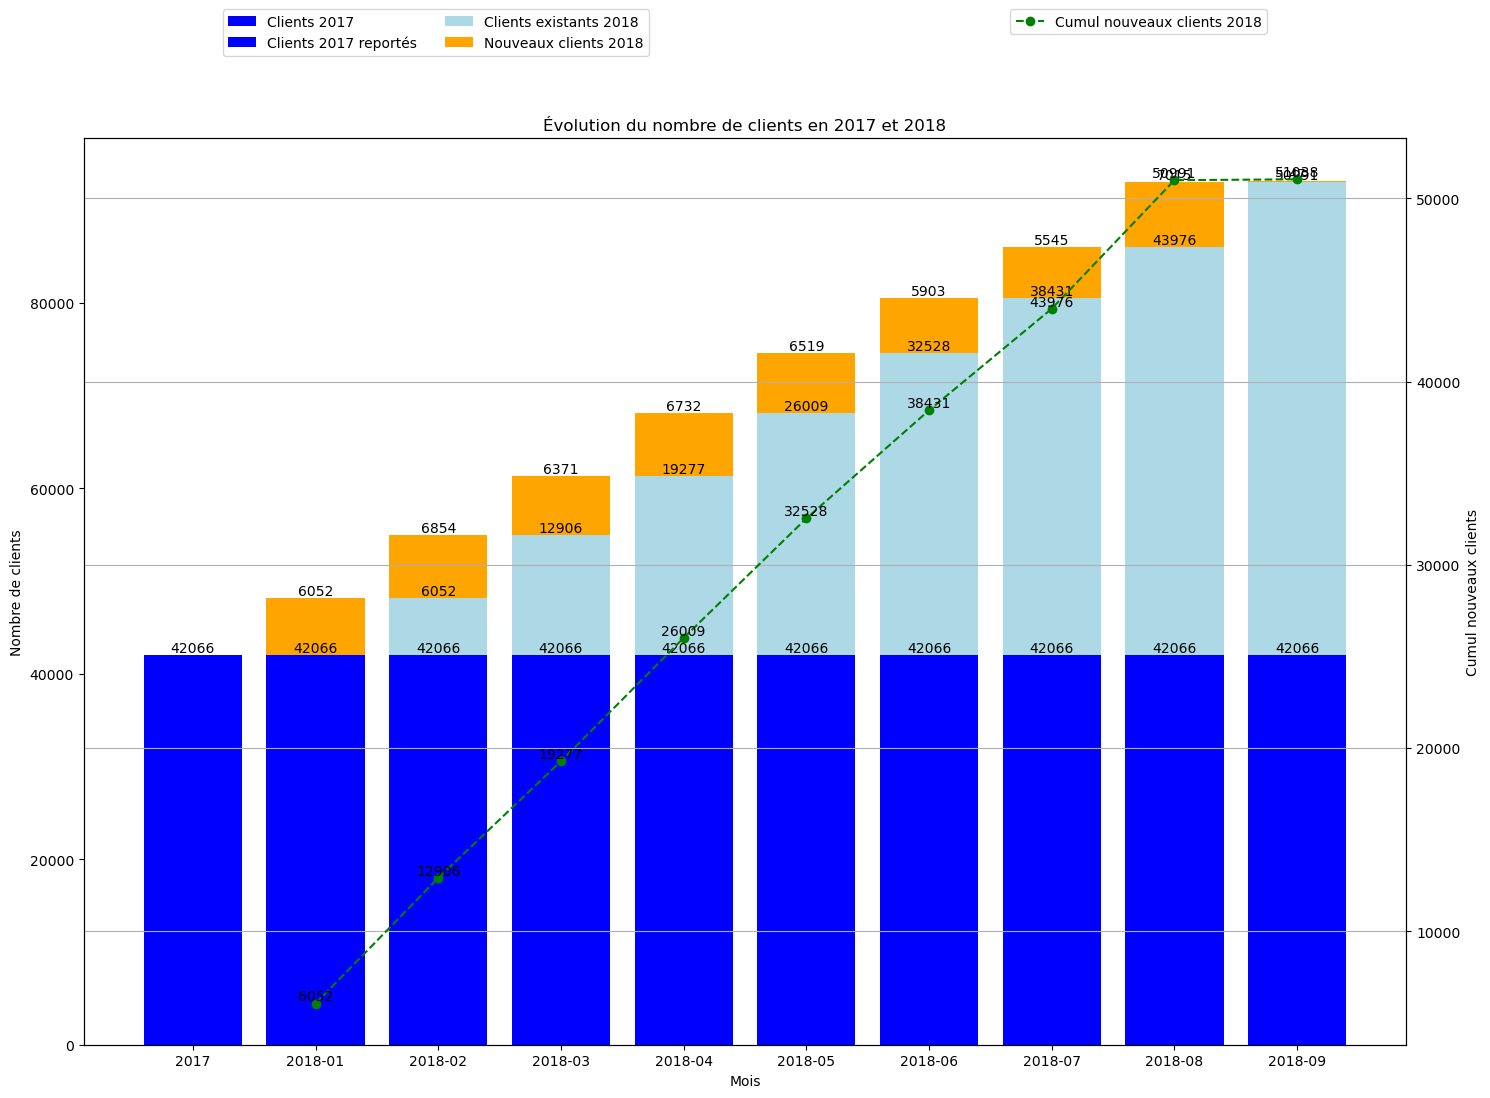

In [10]:
# Calcul du nombre de clients en 2017
clients_2017 = set(df_2017['customer_unique_id'])
num_clients_2017 = len(clients_2017)

# Initialisation des structures pour les calculs mensuels de 2018
new_clients_2018 = {}
existing_clients_2018 = {}
cumulative_clients_2018 = clients_2017.copy()

for month, df in results_2018.items():
    current_clients = set(df['customer_unique_id'])
    new_clients = current_clients - cumulative_clients_2018
    new_clients_2018[month] = len(new_clients)
    cumulative_clients_2018.update(new_clients)
    existing_clients_2018[month] = len(current_clients - clients_2017 - new_clients)

# Création des listes pour les mois, les nombres de clients et les nouveaux clients
months_2018 = list(results_2018.keys())
new_clients_2018_list = list(new_clients_2018.values())
existing_clients_2018_list = list(existing_clients_2018.values())

# Initialisation de la figure
fig, ax1 = plt.subplots(figsize=(15, 11))

# Barres pour les clients de 2017 en bleu
ax1.bar('2017', num_clients_2017, color='blue', label='Clients 2017')
ax1.text('2017', num_clients_2017, str(num_clients_2017), ha='center', va='bottom')

# Barres pour les clients de 2017 reportés chaque mois de 2018 en bleu
ax1.bar(months_2018, [num_clients_2017] * len(months_2018), color='blue', label='Clients 2017 reportés')
for i, month in enumerate(months_2018):
    ax1.text(month, num_clients_2017, str(num_clients_2017), ha='center', va='bottom')

# Barres pour les clients existants de 2018 (hors nouveaux clients et clients de 2017) en bleu clair
bottoms = [num_clients_2017] * len(months_2018)
ax1.bar(months_2018[1:], existing_clients_2018_list[1:], bottom=bottoms[1:], color='lightblue', label='Clients existants 2018')
for i, (month, existing_clients) in enumerate(zip(months_2018[1:], existing_clients_2018_list[1:]), 1):
    ax1.text(month, bottoms[i] + existing_clients, str(existing_clients), ha='center', va='bottom')
    bottoms[i] += existing_clients

# Barres pour les nouveaux clients de 2018 en orange
ax1.bar(months_2018, new_clients_2018_list, bottom=bottoms, color='orange', label='Nouveaux clients 2018')
for i, (month, new_clients) in enumerate(zip(months_2018, new_clients_2018_list)):
    ax1.text(month, bottoms[i] + new_clients, str(new_clients), ha='center', va='bottom')

# Ajout de la courbe pour le total des nouveaux clients sur 2018
cumulative_new_clients_2018 = np.cumsum(new_clients_2018_list)
ax2 = ax1.twinx()
ax2.plot(months_2018, cumulative_new_clients_2018, color='green', marker='o', linestyle='--', label='Cumul nouveaux clients 2018')
for i, (month, total_new_clients) in enumerate(zip(months_2018, cumulative_new_clients_2018)):
    ax2.text(month, total_new_clients, str(total_new_clients), ha='center', va='bottom')

# Ajout des labels et titre
ax1.set_xlabel('Mois')
ax1.set_ylabel('Nombre de clients')
ax2.set_ylabel('Cumul nouveaux clients')
ax1.set_title('Évolution du nombre de clients en 2017 et 2018')

# Rendre le graphique plus esthétique
ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 1.15), ncol=2)
ax2.legend(loc='upper right', bbox_to_anchor=(0.9, 1.15))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Affichage du graphique
plt.show()


## 3. Calculer les variations sur Ariscore des clients de 2017, sur l'année de 2018

Dans cette partie nous allons calculer le ariscore sur chaque de 2018 pour les clients de 2017. Tout en tenant compte de l'arrivée chaque mois des nouveaux clients.

In [11]:
# Charger le modèle K-means
kmeans_model = joblib.load('kmeans_model_k=8.pkl')

# Normalisation des données
scaler = StandardScaler()

# Fonction de normalisation et de prédiction des clusters
def normalize_and_predict(df, kmeans_model, scaler):
    features = df[['total_orders', 'total_items', 'payment_value',
                   'total_characters_review_comment_message', 'avg_product_weight_g',
                   'avg_product_volume_cm3', 'avg_review_score', 'time_shipping',
                   'ecart_Prev', 'time_since_last_purch',
                   'tot_orders_2016', 'tot_orders_2017', 'tot_orders_2018',
                   'freight_payment_ratio', 'single_mult_order']]
    features = scaler.transform(features)
    clusters = kmeans_model.predict(features)
    return clusters

# Agrégation pour l'année 2017
df_2017 = transformer_aggregations(df_ari, start_date='2017-01-01', end_date='2017-12-31')

# Normaliser les données de 2017
scaler.fit(df_2017[['total_orders', 'total_items', 'payment_value',
                    'total_characters_review_comment_message', 'avg_product_weight_g',
                    'avg_product_volume_cm3', 'avg_review_score', 'time_shipping',
                    'ecart_Prev', 'time_since_last_purch',
                    'tot_orders_2016', 'tot_orders_2017', 'tot_orders_2018',
                    'freight_payment_ratio', 'single_mult_order']])
clusters_2017 = normalize_and_predict(df_2017, kmeans_model, scaler)

# Calcul des clusters et ARI score pour chaque mois de 2018 jusqu'à septembre
ariscores_2018 = {}

for month in range(1, 10):  # Arrêter à septembre (mois 9)
    start_date = '2017-01-01'
    end_date = f'2018-{month:02d}-28'  # Assurez-vous de gérer les mois avec différentes durées
    df_month = transformer_aggregations(df_ari, start_date=start_date, end_date=end_date)
    
    # Filtrer pour garder seulement les clients présents en 2017
    df_month = df_month[df_month['customer_unique_id'].isin(df_2017['customer_unique_id'])]
    
    # Réaligner les dataframes
    df_month = df_month.set_index('customer_unique_id').reindex(df_2017['customer_unique_id']).reset_index()
    
    clusters_month = normalize_and_predict(df_month, kmeans_model, scaler)
    
    ariscore = adjusted_rand_score(clusters_2017, clusters_month)
    ariscores_2018[f'2018-{month:02d}'] = ariscore

# Affichage des ARI scores
print("ARI scores pour chaque mois de 2018:")
for key, score in ariscores_2018.items():
    print(f"{key}: {score}")


ARI scores pour chaque mois de 2018:
2018-01: 0.9699280697898295
2018-02: 0.9351223071063466
2018-03: 0.8963569124300125
2018-04: 0.841746050274588
2018-05: 0.7796219242107947
2018-06: 0.702345759961926
2018-07: 0.6094050485701753
2018-08: 0.5063247603291393
2018-09: 0.5013989893883367


## 4. Visualisation des variations du ariscore

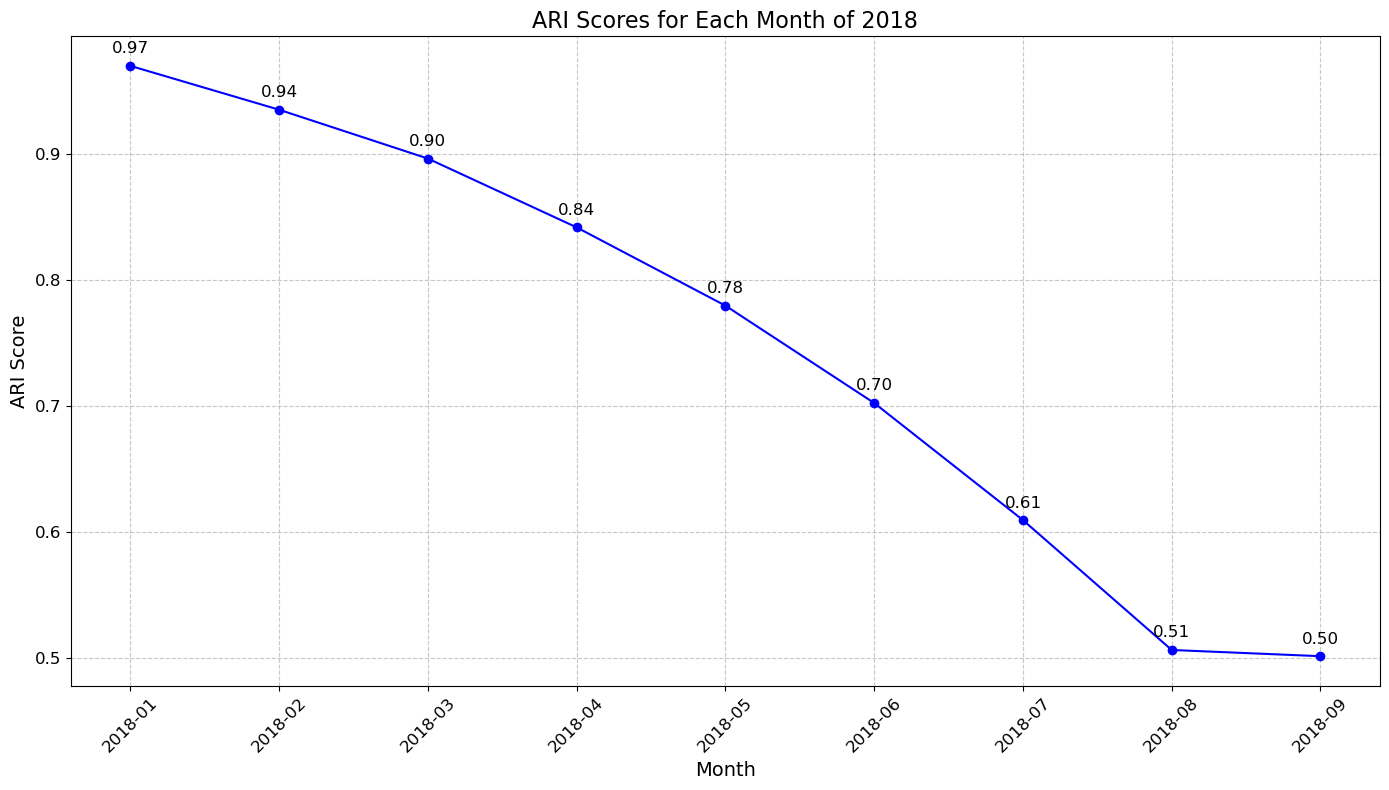

In [12]:
# Génération du graphique
months = list(ariscores_2018.keys())
scores = list(ariscores_2018.values())

# Création du graphique
plt.figure(figsize=(14, 8))
plt.plot(months, scores, marker='o', linestyle='-', color='b')
plt.title('ARI Scores for Each Month of 2018', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('ARI Score', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Ajout des étiquettes de valeurs
for i, score in enumerate(scores):
    plt.text(months[i], score + 0.01, f'{score:.2f}', ha='center', fontsize=12, color='black')

plt.show()

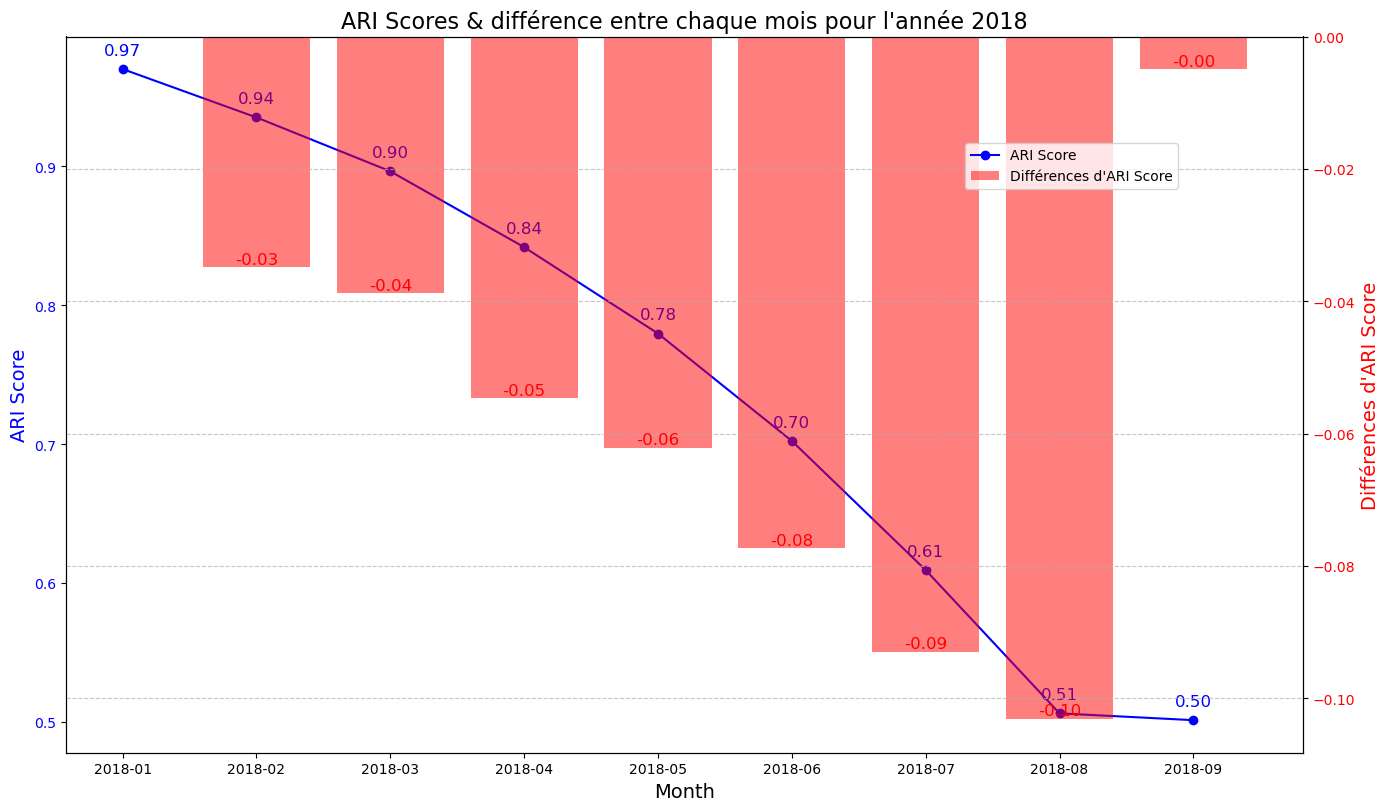

In [22]:
# Calcul des différences d'ARI score entre chaque mois
months = list(ariscores_2018.keys())
scores = list(ariscores_2018.values())
diffs = [scores[i] - scores[i - 1] for i in range(1, len(scores))]

# Création du graphique avec deux axes Y
fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('ARI Score', fontsize=14, color='b')
ax1.plot(months, scores, marker='o', linestyle='-', color='b', label='ARI Score')
ax1.tick_params(axis='y', labelcolor='b')

# Ajout des étiquettes de valeurs pour les scores
for i, score in enumerate(scores):
    ax1.text(months[i], score + 0.01, f'{score:.2f}', ha='center', fontsize=12, color='b')

ax2 = ax1.twinx()  # Instancie un second axe qui partage le même axe x
ax2.set_ylabel('Différences d\'ARI Score', fontsize=14, color='r')
bars = ax2.bar(months[1:], diffs, color='r', alpha=0.5, label='Différences d\'ARI Score')
ax2.tick_params(axis='y', labelcolor='r')

# Ajout des étiquettes de données sur les barres
for bar, diff in zip(bars, diffs):
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval, f'{diff:.2f}', ha='center', va='bottom', fontsize=12, color='r')

fig.tight_layout() 
plt.title('ARI Scores & différence entre chaque mois pour l\'année 2018', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Ajout de légendes
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))

plt.show()

Au fil des mois, l'arrivée des nouveaux clients dégrade la stabilité de nos clusters créés pour les clients de 2017. Cette dégradation s'opère de manière progressive, en partant 0.97 à 0.50 à la fin de la période.
Si nous établissons un seuil à 0.85 qui permet d'avoir une certaine stabilité des clusters, une maintenance du modèle devrait être nécessaire tous les 3 mois.